In [21]:
import pandas as pd
from pathlib import Path

# df = pd.read_json("/mnt/yandex_cup24/CoverHunterMPS_data/covers80/val.txt", lines=True)
# df["embed"] = df["feat"].apply(lambda path: Path("training/exp6/val_eval/query_embed") / f"{Path(path).stem}-▁start-0.npy")

df = pd.read_json("training/exp8/val_eval/query.txt", lines=True)
df.columns

Index(['perf', 'wav', 'dur_s', 'work', 'version', 'feat', 'feat_len',
       'work_id', 'start_s', 'start', 'embed'],
      dtype='object')

In [22]:
from pathlib import Path
import numpy as np
from tqdm import tqdm

all_npy_paths = df["embed"].to_list() # list(Path("training/exp6/val_eval/query_embed").glob("*.npy"))
all_embeddings = list()
for npy_path in tqdm(all_npy_paths):
    all_embeddings.append(np.load(npy_path))
all_embeddings = np.asarray(all_embeddings)

100%|██████████| 15885/15885 [00:00<00:00, 22872.51it/s]


In [23]:
from random import shuffle

import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler

ids = sorted(df["work_id"].unique())
work_id_normilized = np.asarray([ids.index(value) for value in df["work_id"].values])

print("StandardScaler training")
all_embeddings_scaled = StandardScaler().fit_transform(all_embeddings)

print("Umap training")
reducer = umap.UMAP()
# embedding = reducer.fit_transform(all_embeddings)
embedding = reducer.fit_transform(all_embeddings_scaled)

StandardScaler training
Umap training


Colors num: 2197


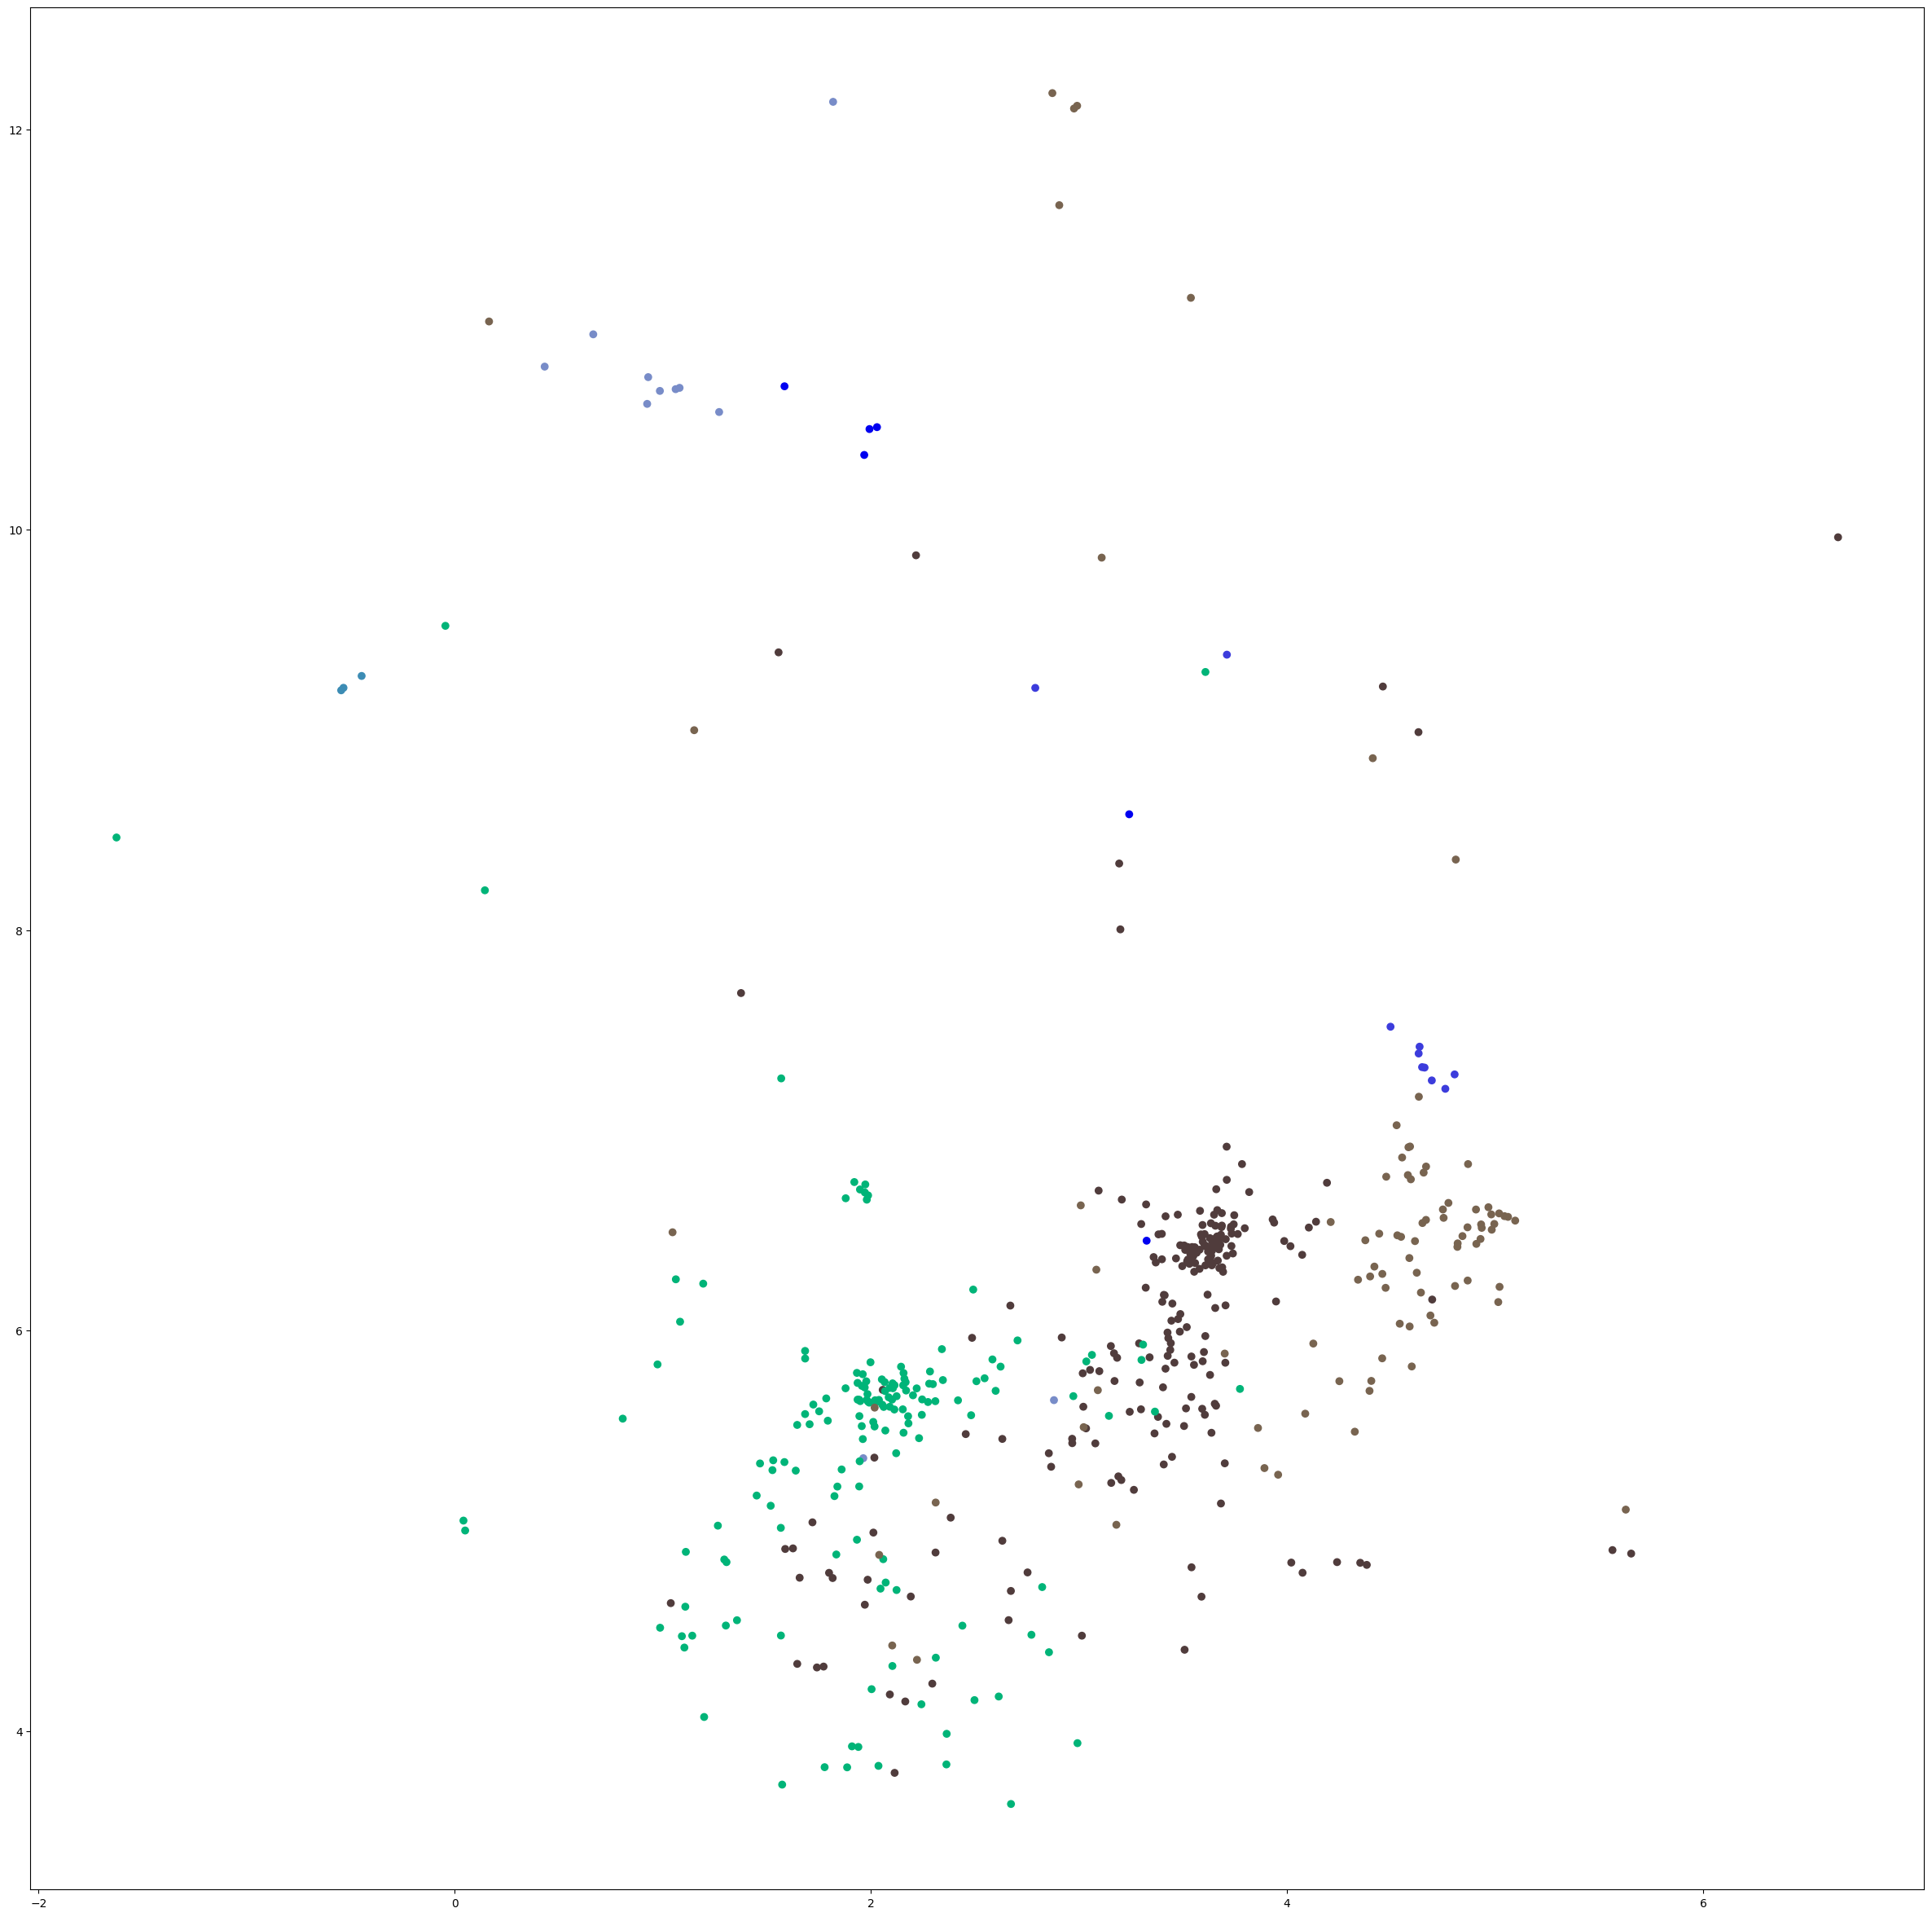

In [24]:
step = 20
collors = np.asarray([(r / 255, g / 255 , b / 255) for r in range(0, 255, step) for g in range(0, 255, step) for b in range(0, 255, step)])
shuffle(collors)
print("Colors num:", len(collors))

plt.rcParams["figure.figsize"] = (30, 30)
plt.scatter(embedding[:500, 0], embedding[:500, 1], c=collors[work_id_normilized[:500]][:])
plt.show()

In [5]:
# ids = sorted(df["work_id"].unique())
# work_id_normilized = np.asarray([ids.index(value) for value in df["work_id"].values])

In [6]:
# import umap

# reducer = umap.UMAP()
# embedding = reducer.fit_transform(all_embeddings)

In [7]:
# import matplotlib.pyplot as plt
# from random import shuffle

# step = 20

# collors = np.asarray([(r / 255, g / 255 , b / 255) for r in range(0, 255, step) for g in range(0, 255, step) for b in range(0, 255, step)])
# shuffle(collors)
# print(len(collors))


# plt.rcParams["figure.figsize"] = (30, 30)
# # cmap = plt.cm.get_cmap('jet', df.work_id.nunique())
# cmap = plt.get_cmap('jet', df.work_id.nunique())
# plt.scatter(embedding[:, 0], embedding[:, 1], c=collors[work_id_normilized][:])
# plt.show()

In [8]:
version2work = {version: work for version, work in df[["version", "work"]].values}
work2versions = dict()
for work, subdf in df.groupby("work"):
    work2versions[work] = set(subdf["version"].to_list())

In [12]:
import os
from collections import defaultdict

from sklearn.cluster import DBSCAN, KMeans, HDBSCAN, AffinityPropagation, MeanShift, OPTICS
from sklearn.metrics import pairwise_distances_chunked, pairwise_distances
from tqdm import tqdm


def train_clusterisation(train_embeddings: np.ndarray, algorithm: str = "dbscan"):
    if algorithm == "dbscan":
        clusterizer = DBSCAN(leaf_size=300, min_samples=3, eps=0.3)
    elif algorithm == "hdbscan":
        clusterizer = HDBSCAN(min_cluster_size=5)
    elif algorithm == "kmeans":
        clusterizer = KMeans(n_clusters=2000)
    elif algorithm == "affinitypropagation":
        clusterizer = AffinityPropagation()
    elif algorithm == "meanshift":
        clusterizer = MeanShift(min_bin_freq=2)
    elif algorithm == "optics":
        clusterizer = OPTICS()
    
    print(f"{algorithm} training")
    clusterizer = clusterizer.fit(train_embeddings)
    return clusterizer

def evaluate_nearest_to_average(clusterizer: DBSCAN | KMeans, versions: np.ndarray, eval_embeddings):
    # embeddings_to_average = dict[int, list]()
    embeddings_to_average = defaultdict[int, list[np.ndarray]](list)

    for version, label, embedding in tqdm(zip(versions, clusterizer.labels_, eval_embeddings), total=len(clusterizer.labels_)):
        # label = version2work[version]
        if label != -1:
            embeddings_to_average[label].append(embedding)

    predicted_embed = defaultdict[int, list[np.ndarray]](list)
    for version, label, embedding in tqdm(zip(versions, clusterizer.labels_, eval_embeddings), total=len(clusterizer.labels_)):
        # label = version2work[version]
        if label != -1:
            predicted_embed[version] = [np.average(embeddings_to_average[label], axis=0)]
        else:
            predicted_embed[version] = [embedding]
    return predicted_embed

def test_procedure_with_labels(
    label2versions: dict[int, list[int]],
    predicted_embed: dict[int, list[np.ndarray]],
    output_dir: str,
    algorithm: str
) -> None:
    trackids: list[int] = []
    embeddings: list[np.array] = []
    for anchor_id, sub_embeddings in predicted_embed.items():
        assert len(sub_embeddings) == 1, f"Too many embeddings: {sub_embeddings}"
        trackids.append(anchor_id)
        embeddings.append(sub_embeddings[0])
    trackids = np.asarray(trackids)
    embeddings = np.asarray(embeddings)

    predictions = []
    for label in label2versions:
        versions = list(label2versions[label])
        label_trackids = trackids[np.where(np.isin(trackids, versions))]
        label_embeddings = embeddings[np.where(np.isin(trackids, versions))]
        for chunk_result in pairwise_distances_chunked(label_embeddings, metric="euclidean", reduce_func=reduce_func):
            for query_indx, query_nearest_items in chunk_result:
                query = label_trackids[query_indx]
                refs = [label_trackids[nn_indx] for nn_indx in query_nearest_items][:100]
                if len(refs) < 100:
                    refs.extend([2 for _ in range(100 - len(refs))])
                predictions.append((query, refs))
    Path(output_dir).mkdir(exist_ok=True, parents=True)
    save_test_predictions(predictions, output_dir, algorithm)
    return predictions

def reduce_func(D_chunk, start):
    top_size = 100
    nearest_items = np.argsort(D_chunk, axis=1)[:, : top_size + 1]
    return [(i, items[items != i]) for i, items in enumerate(nearest_items, start)]

def save_test_predictions(predictions: list, output_dir: str, algorithm: str) -> None:
    with open(os.path.join(output_dir, f"submission_{algorithm}.txt"), "w") as foutput:
        for query_item, query_nearest in predictions:
            foutput.write(
                "{}\t{}\n".format(query_item, "\t".join(map(str, query_nearest)))
            )


def calc_nDCG(submission_path: str, work2versions: dict[int, set[int]], version2work: dict[int, int]):
    submission = pd.read_csv(submission_path, sep="\s", header=None)
    all_ndcg = list()
    work2ndcg = dict()
    
    # with open(submission_path, 'r') as txt_file:
    #     for line in txt_file.readlines():
    #         if line.strip() == "":
    #             continue
    #         line = list(map(int, line.strip().split()))

    for line in tqdm(submission.values):
        preds = list[int]()
        
        work = version2work[line[0]]
        for track_id in line[1:]:
            if track_id in work2versions[work]:
                preds.append(1)
            else:
                preds.append(0)

        num_true = min(len(work2versions[work]) - 1, 100)
        y_true = [*(1 for _ in range(num_true)), *(0 for _ in range(100 - num_true))]
        curr_ndcg = ndcg_at_k(preds, y_true, k=100)
        all_ndcg.append(curr_ndcg)
    return all_ndcg

def ndcg_at_k(preds: list[int], y_true: list[int], k):
    dcg_max = dcg_at_k(y_true, k)
    if not dcg_max:
        return 0.
    return dcg_at_k(preds, k) / dcg_max

def dcg_at_k(preds: list[int], k: int):
    preds = np.asfarray(preds)[:k]
    if preds.size:
        return preds[0] + np.sum(preds[1:] / np.sqrt(np.arange(2, preds.size + 1)))
    return 0.


algorithm = "dbscan"
clusterizer = train_clusterisation(all_embeddings, algorithm)
version2label = {version: label for version, label in zip(df["version"].values, clusterizer.labels_)}
label2versions = defaultdict(list)
for version, label in version2label.items():
    label2versions[label].append(version)

# predicted_embed = evaluate_nearest_to_average(clusterizer, df["version"].values, all_embeddings)
predicted_embed = {version: [embedding] for version, embedding in zip(df["version"].values, all_embeddings)}
# _ = test_procedure(predicted_embed, "training/exp6/val_eval/", algorithm)
test_procedure_with_labels(label2versions, predicted_embed, "training/exp8/val_eval/", algorithm)
# test_procedure_with_labels(work2versions, predicted_embed, "training/exp6/val_eval/", algorithm)

ndcg_base = calc_nDCG("training/exp8/val_eval/submission.txt", work2versions, version2work)
print("nDCG w/o clusterisation:", sum(ndcg_base) / len(ndcg_base))

ndcg_clusterized = calc_nDCG(f"training/exp8/val_eval/submission_{algorithm}.txt", work2versions, version2work)
print(f"nDCG w/ {algorithm}:", sum(ndcg_clusterized) / len(ndcg_clusterized))

dbscan training


/tmp/ipykernel_29446/1565196446.py:90: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  submission = pd.read_csv(submission_path, sep="\s", header=None)
100%|██████████| 15885/15885 [00:00<00:00, 30342.16it/s]
/tmp/ipykernel_29446/1565196446.py:90: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  submission = pd.read_csv(submission_path, sep="\s", header=None)


nDCG w/o clusterisation: 0.5309814989899907


100%|██████████| 15885/15885 [00:00<00:00, 30081.40it/s]

nDCG w/ dbscan: 0.5272750943578985


In [ ]:
# exp8
# nDCG w/o clusterisation: 0.5309814989899907
# nDCG w/ dbscan: 0.47093256989100746
# nDCG w/ meanshift: 0.5309814989899907

In [ ]:
# exp7
# nDCG w/o clusterisation: 0.4859570997585422
# nDCG w/ dbscan: 0.47093256989100746
# nDCG w/ hdbscan: 0.4244384958497507
# nDCG w/ affinitypropagation: 0.3227526172823279
# nDCG w/ meanshift: 0.487495632981647
# nDCG w/ optics: 0.4586910749162928

In [415]:
work2versions[3]

{150441, 273220, 336003}

In [408]:
for val, l in work2versions.items():
    print(val, len(l))

3 3
23 3
43 2
63 2
83 2
103 5
123 12
143 3
163 4
183 11
203 11
223 4
243 49
263 2
283 2
303 2
323 2
343 3
363 32
383 4
403 2
423 3
443 8
463 11
483 2
503 2
523 2
543 3
563 8
583 3
603 3
623 2
643 4
663 2
683 23
703 242
723 2
743 2
763 7
783 2
803 3
823 4
843 2
863 4
883 3
903 3
923 2
943 31
963 2
983 6
1003 7
1023 2
1043 2
1063 3
1083 3
1103 3
1123 3
1143 7
1163 12
1183 2
1203 2
1223 2
1243 2
1263 2
1283 12
1303 7
1323 3
1343 3
1363 2
1383 2
1403 4
1423 3
1443 3
1463 8
1483 2
1503 2
1523 2
1543 2
1563 14
1583 2
1603 4
1623 5
1643 15
1663 27
1683 2
1703 4
1723 2
1743 5
1763 2
1783 17
1803 4
1823 6
1843 2
1863 42
1883 4
1903 3
1923 2
1943 3
1963 14
1983 2
2003 12
2023 2
2043 3
2063 41
2083 4
2103 2
2123 5
2143 2
2163 3
2183 5
2203 3
2223 22
2243 3
2263 6
2283 2
2303 6
2323 2
2343 2
2363 4
2383 3
2403 2
2423 13
2443 2
2463 4
2483 4
2503 2
2523 5
2543 6
2563 3
2583 5
2603 4
2623 2
2643 29
2663 2
2683 4
2703 4
2723 5
2743 6
2763 2
2783 3
2803 6
2823 3
2843 3
2863 2
2883 3
2903 2
2923 4
2943

In [367]:
from sklearn.cluster import DBSCAN, KMeans

# dbscan = DBSCAN(leaf_size=300, min_samples=2, eps=0.3)
dbscan = DBSCAN(leaf_size=300, min_samples=3, eps=0.3)
dbscan = dbscan.fit(all_embeddings)

In [368]:
# dbscan = KMeans(n_clusters=4000).fit(all_embeddings)

In [369]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75])

In [376]:
from tqdm import tqdm

embeddings_to_average = dict[int, list]()

for version, label, embedding in tqdm(zip(df["version"].values, dbscan.labels_, all_embeddings), total=len(dbscan.labels_)):
    # label = version2work[version]
    if label != -1:
        if label not in embeddings_to_average:
            embeddings_to_average[label] = [embedding]
        else:
            embeddings_to_average[label].append(embedding)

predicted_embed = dict[int, list[np.ndarray]]()
for version, label, embedding in tqdm(zip(df["version"].values, dbscan.labels_, all_embeddings), total=len(dbscan.labels_)):
    # label = version2work[version]
    if label != -1:
        predicted_embed[version] = [np.average(embeddings_to_average[label], axis=0)]
    else:
        predicted_embed[version] = [embedding]

100%|██████████| 15885/15885 [00:00<00:00, 100458.55it/s]


In [377]:
import os
from sklearn.metrics import pairwise_distances_chunked

def test_procedure(predicted_embed: dict[str, list[np.ndarray]], output_dir: str) -> None:
    trackids: list[int] = []
    embeddings: list[np.array] = []
    for anchor_id, sub_embeddings in predicted_embed.items():
        assert len(sub_embeddings) == 1, f"Too many embeddings: {sub_embeddings}"
        trackids.append(anchor_id)
        embeddings.append(sub_embeddings[0])

    predictions = []
    for chunk_result in pairwise_distances_chunked(embeddings, metric="euclidean", reduce_func=reduce_func, working_memory=1000):
        for query_indx, query_nearest_items in chunk_result:
            predictions.append(
                (trackids[query_indx], [trackids[nn_indx] for nn_indx in query_nearest_items][:100])
            )
    Path(output_dir).mkdir(exist_ok=True, parents=True)
    save_test_predictions(predictions, output_dir)
    return predictions

def reduce_func(D_chunk, start):
    top_size = 100
    nearest_items = np.argsort(D_chunk, axis=1)[:, : top_size + 1]
    return [(i, items[items != i]) for i, items in enumerate(nearest_items, start)]

def save_test_predictions(predictions: list, output_dir: str) -> None:
    with open(os.path.join(output_dir, "submission_dbscan.txt"), "w") as foutput:
        for query_item, query_nearest in predictions:
            foutput.write(
                "{}\t{}\n".format(query_item, "\t".join(map(str, query_nearest)))
            )

In [378]:
# predicted_embeddings = [for ]
_ = test_procedure(predicted_embed, "training/exp6/val_eval/")

In [379]:
from tqdm import tqdm

def calc_nDCG(submission_path: str, work2versions: dict[int, set[int]], version2work: dict[int, int]):
    submission = pd.read_csv(submission_path, sep="\s", header=None)
    all_ndcg = list()
    work2ndcg = dict()
    for line in tqdm(submission.values):
        preds = list[int]()
        
        work = version2work[line[0]]
        for track_id in line[1:]:
            if track_id in work2versions[work]:
                preds.append(1)
            else:
                preds.append(0)

        y_true = [1 for _ in preds]
        curr_ndcg = ndcg_at_k(preds, y_true, k=100)
        all_ndcg.append(curr_ndcg)
    return all_ndcg

def ndcg_at_k(preds: list[int], y_true: list[int], k):
    dcg_max = dcg_at_k(y_true, k)
    if not dcg_max:
        return 0.
    return dcg_at_k(preds, k) / dcg_max

def dcg_at_k(preds: list[int], k: int):
    preds = np.asfarray(preds)[:k]
    if preds.size:
        return preds[0] + np.sum(preds[1:] / np.sqrt(np.arange(2, preds.size + 1)))
    return 0.


# # submission_path = "training/exp6/test_eval/submission.txt"
# submission_path = "training/exp6/val_eval/submission.txt"
# all_ndcg = calc_nDCG(submission_path, work2versions, version2work)

In [380]:
all_ndcg = calc_nDCG("training/exp6/val_eval/submission.txt", work2versions, version2work)
print(sum(all_ndcg) / len(all_ndcg))

all_ndcg = calc_nDCG("training/exp6/val_eval/submission_dbscan.txt", work2versions, version2work)
print(sum(all_ndcg) / len(all_ndcg))

/tmp/ipykernel_1464092/2736079482.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  submission = pd.read_csv(submission_path, sep="\s", header=None)
100%|██████████| 15885/15885 [00:00<00:00, 31116.89it/s]
/tmp/ipykernel_1464092/2736079482.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  submission = pd.read_csv(submission_path, sep="\s", header=None)


0.21958028312422984


100%|██████████| 15885/15885 [00:00<00:00, 31478.59it/s]

0.22076561087349236


In [265]:
sum(all_ndcg) / len(all_ndcg)

0.2203084159629382

In [154]:
df

,perf,wav,dur_s,work,version,feat,feat_len,work_id
0,343230,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,60,30463,343230,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,50,30462
1,345928,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,60,30463,345928,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,50,30462
2,347507,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,60,30463,347507,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,50,30462
3,349764,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,60,30463,349764,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,50,30462
4,337373,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,60,30463,337373,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,50,30462
...,...,...,...,...,...,...,...,...
15880,100586,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,60,10203,100586,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,50,10202
15881,98389,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,60,20743,98389,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,50,20742
15882,74842,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,60,20743,74842,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,50,20742
15883,101403,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,60,32083,101403,/mnt/yandex_cup24/CoverHunterMPS_data/covers80...,50,32082


In [119]:
def ndcg(rel_true, rel_pred, p=None, form="linear"):
    """ Returns normalized Discounted Cumulative Gain

    Args:
        rel_true (1-D Array): relevance lists for particular user, (n_songs,)
        rel_pred (1-D Array): predicted relevance lists, (n_pred,)
        p (int): particular rank position
        form (string): two types of nDCG formula, 'linear' or 'exponential'

    Returns:
        ndcg (float): normalized discounted cumulative gain score [0, 1]
    """
    rel_true = np.sort(rel_true)[::-1]
    p = min(len(rel_true), min(len(rel_pred), p))
    discount = 1 / (np.log2(np.arange(p) + 2))

    if form == "linear":
        idcg = np.sum(rel_true[:p] * discount)
        dcg = np.sum(rel_pred[:p] * discount)
    elif form == "exponential" or form == "exp":
        idcg = np.sum([2**x - 1 for x in rel_true[:p]] * discount)
        dcg = np.sum([2**x - 1 for x in rel_pred[:p]] * discount)
    else:
        raise ValueError("Only supported for two formula, 'linear' or 'exp'")

    return dcg / idcg

In [114]:
y_true_nd = np.zeros(shape=(5, 6))
y_true_nd[:, [1,2,3]] = 1
y_true_nd

array([[0., 1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 0., 0.]])

In [117]:
y_pred_nd = np.zeros(shape=(5, 6))
y_pred_nd[np.arange(5), [0, 0, 0, 0, 0]] = 1
y_pred_nd

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [118]:
ndcg_score(y_true_nd, y_pred_nd)

0.6489185207888076

In [139]:
def dcg_at_k(preds: list[int], k: int):
    preds = np.asfarray(preds)[:k]
    if preds.size:
        return preds[0] + np.sum(preds[1:] / np.sqrt(np.arange(2, preds.size + 1)))
    return 0.


def ndcg_at_k(preds: list[int], y_true: list[int], k):
    dcg_max = dcg_at_k(y_true, k)
    if not dcg_max:
        return 0.
    return dcg_at_k(preds, k) / dcg_max

In [132]:
preds = np.asarray([1,1])
preds[1:] / np.sqrt(np.arange(2, preds.size + 1))

array([0.70710678])

In [121]:
ndcg(y_true_nd, y_pred_nd, p=100)

ValueError: operands could not be broadcast together with shapes (5,6) (5,) 

In [84]:
# true_relevance = np.asarray([[10, 0, 0, 1, 5]])
# true_relevance = np.asarray([[1 / np.sqrt(pos) for pos in range(1, 6)]])
true_relevance = np.asarray(
    [
        [0, 0, 0, 0, 1],
        [0, 0, 1, 0, 1],
        [1, 0, 0, 0, 1],
        [0, 0, 1, 0, 1],
        [0, 0, 0, 0, 1],
    ]
)
scores = np.asarray(
    [
        [0, 0, 1, 0, 1],
        [0, 0, 1, 0, 1],
        [0, 0, 1, 0, 1],
        [0, 0, 1, 0, 1],
        [0, 0, 1, 0, 1],
    ]
)
# scores = np.asarray([[0., 0.0, 0.0, 0.0, 0.0]])

true_relevance

array([[0, 0, 0, 0, 1],
       [0, 0, 1, 0, 1],
       [1, 0, 0, 0, 1],
       [0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1]])

In [88]:
# Current form of ground truth and predictions
y_true = [5, 4, 3, 2, 1]
y_pred = [5, 4, 3, 2, 0]
# Transform ground truth to ndarray
y_true_nd = np.zeros(shape=(5, 6))
y_true_nd[np.arange(5), y_true] = 1
# Transform predictions to ndarray
y_pred_nd = np.zeros(shape=(5, 6))
y_pred_nd[np.arange(5), y_pred] = 1
# Calculate ndcg score
ndcg_score(y_true_nd, y_pred_nd)

0.8921866522394966

In [89]:
y_true_nd.shape

(5, 6)

In [81]:
ndcg_score([[5, 4, 3, 2, 1]], [[5, 4, 3, 2, 0]])

1.0

In [80]:
ndcg_score(true_relevance, scores, k=5)

1.0